## Cường độ, thời gian kéo dài và tần suất của các trận mưa có đặc điểm gì?

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] = 'DejaVu Sans'

df = pd.read_csv('hcm_weather_processed.csv')
df['datetime'] = pd.to_datetime(df['datetime'])

df = df.sort_values(by=['location_id', 'datetime'])

In [51]:
# xác định những dòng ghi nhận thời điểm có mưa (>0.1mm)
RAIN_THRESHOLD = 0.1
df['is_raining'] = df['precipitation (mm)'] >= RAIN_THRESHOLD

# xác định các cơn mưa (gom những dòng có mưa liên tục vào 1 cơn mưa)
df['block_id'] = (
    (df['is_raining'] != df['is_raining'].shift()) |
    (df['location_id'] != df['location_id'].shift())
).cumsum()

# tạo df chứa thông tin các trận mưa
rain_events = df[df['is_raining']].groupby('block_id').agg(
    start_time=('datetime', 'min'),
    duration_hours=('datetime', 'count'),
    total_rainfall=('precipitation (mm)', 'sum'),
    max_intensity=('precipitation (mm)', 'max'),
    month=('month', 'first')
).reset_index()

# phân loại mức độ mưa
def categorize_rain(mm):
    if mm < 2.5: return 'Mưa Nhỏ (<2.5mm)'
    elif mm < 10: return 'Mưa Vừa (2.5-10mm)'
    elif mm < 50: return 'Mưa To (10-50mm)'
    else: return 'Mưa Rất To (>50mm)'

rain_events['intensity_class'] = rain_events['max_intensity'].apply(categorize_rain)

In [52]:
# xét xem ngày nào là "ngày mưa" trong số những ngày có mưa
df['date'] = df['datetime'].dt.date
daily_rain = df.groupby(['location_id', 'date'])['precipitation (mm)'].sum().reset_index()
daily_rain['is_rainy_day'] = daily_rain['precipitation (mm)'] >= 1.0 # 1mm threshold for a "rainy day"

# chuẩn hoá lượng mưa trung bình của những "ngày mưa" (8 vị trí, 2 năm)
factor = 8 * 2
monthly_rainy_counts = daily_rain[daily_rain['is_rainy_day']].groupby(pd.to_datetime(daily_rain['date']).dt.month)['date'].count()
monthly_rainy_days_avg = monthly_rainy_counts / factor

# số lượng các trận mưa theo mức độ
freq_counts = rain_events['intensity_class'].value_counts()
# số lượng trận mưa to
heavy_rain_count = len(rain_events[rain_events['max_intensity'] >= 10])

# chu kỳ mưa: tổng thời gian theo dõi / tổng số cơn mưa (trung bình 1 trạm)
n_locations = df['location_id'].nunique()
total_hours = len(df) / n_locations  # tổng giờ gian theo dõi tại 1 trạm
total_events = len(rain_events) / n_locations # tổng số trận mưa tại 1 trạm
interval = total_hours / total_events if total_events > 0 else 0

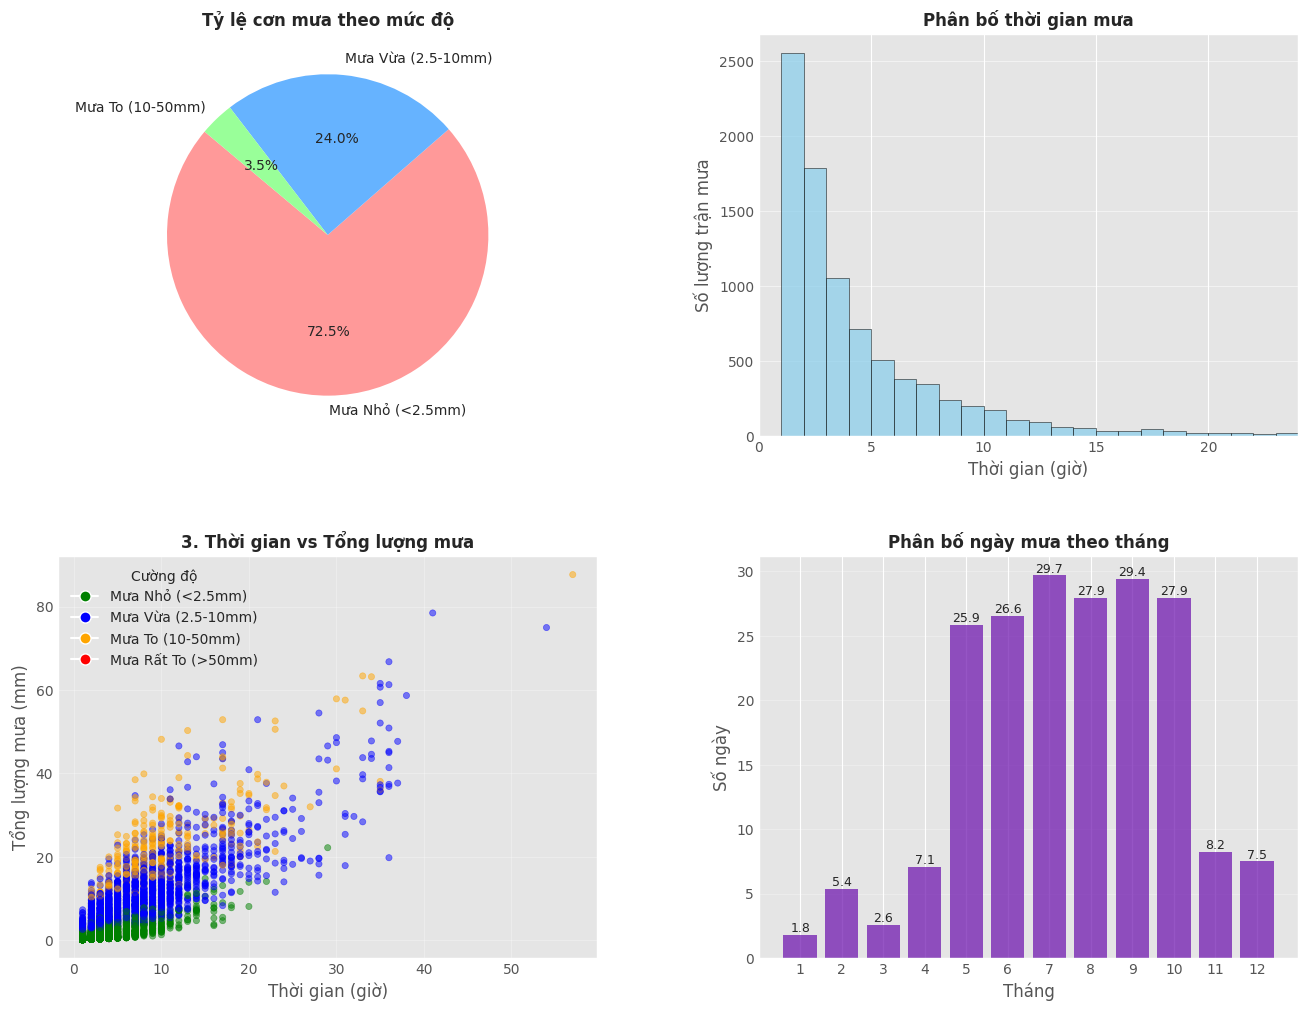

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

# Pie chart: biểu đồ tỉ lệ các cơn mưa theo mức độ
intensity_counts = rain_events['intensity_class'].value_counts()
colors_pie = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
axes[0, 0].pie(intensity_counts, labels=intensity_counts.index, autopct='%1.1f%%',
               startangle=140, colors=colors_pie)
axes[0, 0].set_title('Tỷ lệ cơn mưa theo mức độ', fontsize=12, fontweight='bold')

# Histogram: phân bố thời gian kéo dài mỗi cơn mưa
axes[0, 1].hist(rain_events['duration_hours'], bins=range(1, 25), color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Phân bố thời gian mưa', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Thời gian (giờ)')
axes[0, 1].set_ylabel('Số lượng cơn mưa')
axes[0, 1].set_xlim(0, 24)
axes[0, 1].grid(axis='y', alpha=0.5)

# Scatter plot: tương quan giữa thời gian và tổng lượng mưa
color_map = {'Mưa Nhỏ (<2.5mm)': 'green', 'Mưa Vừa (2.5-10mm)': 'blue', 'Mưa To (10-50mm)': 'orange', 'Mưa Rất To (>50mm)': 'red'}
colors_scatter = rain_events['intensity_class'].map(color_map)

axes[1, 0].scatter(rain_events['duration_hours'], rain_events['total_rainfall'],
                   c=colors_scatter, alpha=0.5, s=20)
axes[1, 0].set_title('Thời gian vs Tổng lượng mưa', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Thời gian (giờ)')
axes[1, 0].set_ylabel('Tổng lượng mưa (mm)')
axes[1, 0].grid(True, alpha=0.3)

from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label=k, markerfacecolor=v, markersize=8) for k, v in color_map.items()]
axes[1, 0].legend(handles=legend_elements, title="Cường độ")

# Bar chart: phân bố ngày mưa theo tháng
months = monthly_rainy_days_avg.index
values = monthly_rainy_days_avg.values
bars = axes[1, 1].bar(months, values, color='#6a0dad', alpha=0.7)
axes[1, 1].set_title('Phân bố ngày mưa theo tháng', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Tháng')
axes[1, 1].set_ylabel('Số ngày')
axes[1, 1].set_xticks(range(1, 13))
axes[1, 1].grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}', ha='center', va='bottom', fontsize=9)

plt.show()

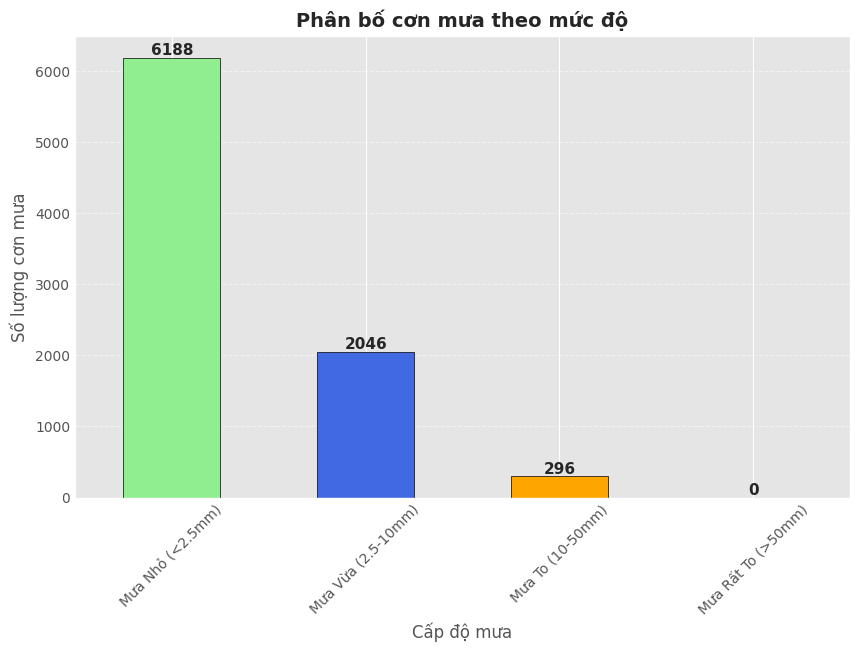

In [66]:
plt.figure(figsize=(10, 6))
colors = ['#90EE90', '#4169E1', '#FFA500', '#FF4500']
ax = freq_counts.reindex(['Mưa Nhỏ (<2.5mm)', 'Mưa Vừa (2.5-10mm)', 'Mưa To (10-50mm)', 'Mưa Rất To (>50mm)']).plot(kind='bar', color=colors, edgecolor='black')

plt.title('Phân bố cơn mưa theo mức độ', fontsize=14, fontweight='bold')
plt.xlabel('Cấp độ mưa')
plt.ylabel('Số lượng cơn mưa')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.show()

In [70]:
print(f"Tổng số trận mưa phân tích: {len(rain_events)}")
print(f"Thời gian mưa trung bình: {rain_events['duration_hours'].mean():.2f} giờ")
print(f"Cường độ lớn nhất ghi nhận: {rain_events['max_intensity'].max()} mm/h")

print(f"\nChu kỳ lặp lại trung bình: Cứ {interval:.1f} giờ có 1 trận mưa")
print(f"Tần suất mưa to (>10mm/h): {heavy_rain_count} trận (Chiếm {heavy_rain_count/len(rain_events)*100:.1f}%)")

Tổng số trận mưa phân tích: 8530
Thời gian mưa trung bình: 4.06 giờ
Cường độ lớn nhất ghi nhận: 24.7 mm/h

Số ngày mưa trung bình vào cao điểm (Tháng 9): 29.4 ngày
Số ngày mưa trung bình vào thấp điểm (Tháng 2): 5.4 ngày

Chu kỳ lặp lại trung bình: Cứ 15.1 giờ có 1 trận mưa
Tần suất mưa to (>10mm/h): 296 trận (Chiếm 3.5%)


## NHẬN XÉT

### 1. Về cường độ mưa

- Từ pie chart, ta thấy phần lớn các trận mưa có cường độ trung bình thấp --> mưa chủ yếu là mưa nhỏ và vừa

- Cường độ mưa được ghi nhận cao nhất là 24.7 mm/h, là mức mưa to

- Phân bố cường độ mưa:

  - Mưa nhỏ (<2.5mm/h): Chiếm đa số.

  - Mưa vừa (2.5 - 10mm/h): Phổ biến trung bình.

  - Mưa to (>10mm/h): Ít gặp hơn, thường là các cơn dông nhiệt ngắn.

### 2. Về độ dài cơn mưa

- Thời gian trung bình: một trận mưa ở các khu vực kéo dài trung bình khoảng 4.06 giờ.

- Phân bố:

  - 25% số trận mưa chỉ kéo dài 1 giờ

  - 50% số trận mưa kéo dài dưới 2 giờ

  - Chỉ có 10% số trận mưa kéo dài quá 9 giờ

Kết luận: Mưa ở đây có đặc điểm là nhanh đến nhanh đi (đặc trưng của mưa dông nhiệt đới). Những trận mưa dầm dề cả ngày rất hiếm (dưới 1%).

### 3. Về tần suất mưa

- Tổng số trận mưa: 8,530 cơn mưa tách biệt trên 8 trạm đo được ghi nhận trong suốt giai đoạn 2024-2025

- Tần suất xuất hiện dày đặc vào các tháng mùa mưa (Tháng 5 - 11).

- Tháng 7,8,9,10 thường có số lượng trận mưa nhiều nhất.

- Các tháng mùa khô (ví dụ như tháng 1, 2, 3) số lượng trận mưa rất ít, chỉ đếm trên đầu ngón tay.

### Insights rút ra:

1. Mưa tập trung theo mùa rất rõ rệt

    Lượng mưa tăng mạnh từ tháng 5 đến tháng 11, cho thấy cấu trúc mùa mưa–mùa khô ổn định

2. Mưa thường ngắn, hiếm khi kéo dài

3. Phần lớn mưa có cường độ nhỏ đến vừa

4. Hiện tượng ngập nước đô thị có thể do nhiều trận mưa nhỏ-vừa liên tiếp trong ngày/tuần làm hệ thống thoát nước không hồi phục kịp chứ không phải do mưa lớn

5. Mưa mang tính cục bộ theo vị trí

    → Dự báo toàn TP.HCM có vẻ kém hữu ích hơn so với dự báo theo từng quận/khu vực

6. Dự báo mưa ngắn hạn (phạm vi 30-60p) theo thời gian thực là hữu ích, thay vì chỉ là dự báo hôm nay có mưa hay không